<a href="https://colab.research.google.com/github/VinylBr/Project_MTBResistance/blob/main/Project_184026002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Vinay Barnabas <br>
Dataset has around 3800 features and 12000 samples. Owing to this, calculating correlation matrix and TruncatedSVD every time Colab connects to a new runtime virtual machine is cumbersom. <br>
To bypass this, mount on Gdrive and store corr_matrix, truncated_SVD, trained models in Google drive. This would allow me to quickly resume from where I left off.

# Import

In [ ]:
import pandas as pd
import numpy as np
import gdown #to download from gdrive
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
plt.rcParams.update({'font.size':18})
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint as sp_rand
from sklearn.metrics import classification_report
import os #clean way to change directory
import joblib
import plotly.express as px
template = "plotly_dark"
from plotly.subplots import make_subplots

# Upload Datasets
----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("drive/MyDrive/MLData/EE769Project")

In [ ]:
#!gdown https://drive.google.com/uc?id=1-46hUwDdUhE9DGBAkx9gPx6FTvOSiV-c #Download from google drive TEST_LEV.csv

In [ ]:
#!gdown --fuzzy https://drive.google.com/file/d/1EfUa-VdQ1gPcDFtBxKGfh12rragoPr32/view?usp=sharing

In [ ]:
#!gdown --fuzzy https://docs.google.com/spreadsheets/d/1rTu665QFqQd5krMWXC6ge-4He88IT3Zs/edit?usp=sharing&ouid=106623698305590473663&rtpof=true&sd=true

# Command line: Ubuntu executed using windows subsystem for Linux (WSL)

zcat MUTATIONS.csv.gz | awk -F',' '{ if (NF > max_fields) max_fields = NF } END { print max_fields }' *print the maximum field* <br>

zcat MUTATIONS.csv.gz | cut -d ',' -f 2 | tail -n +2 | sort | uniq > genes.txt *get the list of genes* <br>
<br>

zcat DST_MEASUREMENTS.csv.gz | grep "LEV" | grep "CRyPTIC" > DST_LEV.csv <br>
*Get only Drug Susceptibility testing (DST) data for Levofloxacin(LEV) measured by CRyPTIC consortium. Assumption no. 1* <br>

cat DST_LEV.csv | awk -F "," '{print $1}' | uniq  > SAMPLEID.csv
*get only sample IDs where Levofloxacin resistance has been tested* <br>
<br>


zcat MUTATIONS.csv.gz | grep -Fw -f SAMPLEID.csv | gzip > MUTATIONS_redacted.csv.gz *reduce the Mutations dataset* <br>


zcat MUTATIONS_redacted.csv.gz | awk -F "," '{print $1","$2}' | uniq | awk -F',' 'NR>1{genes[$1] = genes[$1] "," $2} END {for (sample in genes) print sample","substr(genes[sample], 2)}' > DATAMATRIX_LEV.csv <br>

*takes only SAMPLEID and Gene names, gets unique values, creates a csv with rows as SAMPLEID and columns as genes*<br>
<br>
<br>

DATAMATRIX_LEV.csv has 11,183 samples <br>
Maximum number of mutated genes in a sample 1544. This is lower than the total number of genes which is around 3862 <br>


zcat DSTMEASUREMENTS.csv.gz | awk -F "," '{print $1","$NF}' | awk -F',' 'NR>1{res[$1] = res[$1] "," $2} END {for (sample in res) print sample","substr(res[sample], 2)}' > RESISTANCESTATUS.csv <br>


IN DST_measurement for LEV with CRyPTIC consortium dataset = 15,224 samples <br>
for LEV alone there were around 20,668 samples <br>
using LEV + CRyPTIC dataset <br>


In [ ]:
df = pd.read_csv("TEST_LEV.csv")
Resistance_status_df = pd.read_csv("DST_LEV.csv")
df_regulation = pd.read_excel("MTB-Signed-TRN.xlsx")

In [ ]:
df.head()

,SAMPLEID,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,...,Rv1836c,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c
0,site.03.subj.GB-83750038.lab.83750038.iso.1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,site.06.subj.SGD_0014-14.lab.06MIL0081.iso.1,0,0,1,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,1,1
2,site.05.subj.LS-0833.lab.LS-10414-18.iso.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,site.20.subj.SCH7887477.lab.YA00134140.iso.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,site.02.subj.0455.lab.251040-15.iso.1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Resistance_status_df.head()

,UNIQUEID,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE
0,site.10.subj.ATCC17052017.lab.ATCC17052017.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,0.5,S
1,site.04.subj.00162.lab.701708.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,>8,R
2,site.02.subj.0517.lab.242314-14.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,<=0.12,S
3,site.04.subj.00404.lab.704942.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,0.25,S
4,site.10.subj.YA00050844.lab.YA00050844.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,0.5,S


In [ ]:
df.columns = df.columns.str.replace("SAMPLEID", "UNIQUEID") #change to allow concat
df_LEV = df.merge(Resistance_status_df[["UNIQUEID","PHENOTYPE"]], how = "left", on = "UNIQUEID") #concat dataframes with the column column UNIQUEID along axis 1 (columns), by keeping intersection of UNIQUEIDs
df_LEV['PHENOTYPE'] = df_LEV['PHENOTYPE'].map({'R':1, 'S':0})

**Check

In [ ]:
df_LEV.head()

,UNIQUEID,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,...,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,site.03.subj.GB-83750038.lab.83750038.iso.1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,site.06.subj.SGD_0014-14.lab.06MIL0081.iso.1,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0
2,site.05.subj.LS-0833.lab.LS-10414-18.iso.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,site.20.subj.SCH7887477.lab.YA00134140.iso.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,site.02.subj.0455.lab.251040-15.iso.1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_LEV.iloc[:,-20:] #print the last 20 columns

,Rv3192,Rv3541c,Rv3195,Rv3239c,Rv3196,Rv3197,mutA,mutB,Rv0574c,Rv1836c,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11177,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11178,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
11179,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
11180,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Cross Check Mutation info from MUTATIONS.csv.gz file

In [ ]:
df_LEV.iloc[1,df_LEV.loc[0].values==1].head(n = 5) #cross-checked with the original datafile to ensure datamanipulation did not introduce errors

eccB1      0
Rv0008c    1
Rv0575c    1
Rv0964c    1
Rv3669     1
Name: 1, dtype: object

### Crosss Check Resistance info from the DST file <br>
1. Compare the UNIQUEID (0th column) and the resistance levels of 13 drugs

In [ ]:
df_LEV.iloc[:,[0] + list(range(-13,0))]

,UNIQUEID,mutB,Rv0574c,Rv1836c,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,site.03.subj.GB-83750038.lab.83750038.iso.1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,site.06.subj.SGD_0014-14.lab.06MIL0081.iso.1,0,0,1,0,0,0,0,0,0,0,1,1,0
2,site.05.subj.LS-0833.lab.LS-10414-18.iso.1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,site.20.subj.SCH7887477.lab.YA00134140.iso.1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,site.02.subj.0455.lab.251040-15.iso.1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11177,site.10.subj.YA00023062.lab.YA00023062.iso.1,0,0,0,0,0,1,0,0,0,0,0,0,0
11178,site.05.subj.LR-2328.lab.FN-01229-18.iso.1,0,1,1,0,0,0,0,0,0,0,0,0,0
11179,site.02.subj.1078.lab.2014184059.iso.1,0,0,0,0,1,0,0,0,0,0,0,0,0
11180,site.05.subj.PMOP-0597.lab.MOP-148.iso.1,0,0,0,0,1,0,0,0,0,0,0,0,0


## Splitting dataset into test and train

In [ ]:

train_size = 0.8
random_state = 11
X_train, X_test, y_train, y_test = train_test_split(df_LEV.iloc[:,1:-1], df_LEV.iloc[:,-1],train_size = train_size, random_state = random_state, stratify = df_LEV.iloc[:,-1])

df_data = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)

In [ ]:
df_LEV.isna().sum().sum() #Check missing values anywhere in the dataset

0

In [ ]:
df_data.head()

,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,infB,...,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8945 entries, 0 to 8944
Columns: 3862 entries, eccB1 to PHENOTYPE
dtypes: int64(3862)
memory usage: 263.6 MB


**Observations**: <br>
All genes have integer entries <br>
Resistance information (14 drugs) and UNIQUEID are the objects, totally 5 columns

In [ ]:
#df_data.describe() #Does not provide useful information

**Observation**:
Data has ones and zeros <br>
Some genes have mutations in 50% of the isolates like eccB4


#Exploratory Data Analysis

## Get distribution of dataset for different drugs

In [ ]:
df_data.PHENOTYPE

0       1
1       0
2       0
3       0
4       1
       ..
8940    1
8941    1
8942    0
8943    0
8944    0
Name: PHENOTYPE, Length: 8945, dtype: int64

In [ ]:
#fig, ax = plt.subplots(figsize = (10,8))
fig = px.histogram(df_data, x = "PHENOTYPE", template = "plotly_dark", labels = {
    '0': 'Susceptible',
    '1': 'Resistance'
})
fig.update_layout(autosize = False,
                  width = 500,
                  height = 500)
fig.show()

In [ ]:
grouped_data = df_data.iloc[:,1:].groupby(['PHENOTYPE']).mean().reset_index() #grouping based on resistance levels
print(grouped_data)

   PHENOTYPE     eccB2     eccB3    Rv2331     eccB4     eccB5   Rv2499c  \
0          0  0.073774  0.102976  0.041917  0.459410  0.080760  0.014811   
1          1  0.124720  0.065436  0.077181  0.708613  0.052013  0.013423   

     Rv2336      infA      infB  ...   Rv1836c    Rv1003   Rv2366c    Rv1006  \
0  0.132318  0.016487  0.217549  ...  0.151740  0.025150  0.310605  0.034372   
1  0.146532  0.010626  0.172819  ...  0.123043  0.011745  0.397651  0.087808   

    Rv0963c    Rv3651      mutY   Rv1703c      bacA   Rv1882c  
0  0.055051  0.129384  0.085511  0.024731  0.120302  0.044711  
1  0.026286  0.158277  0.072707  0.032998  0.088926  0.071029  

[2 rows x 3861 columns]


In [ ]:
#fig, ax = plt.subplots(figsize = (9,7))
fig = px.scatter(x = grouped_data.iloc[0,1:],
                 y = grouped_data.iloc[1,1:],
                 labels = {'x': 'Susceptible',
                           'y': 'Resistant'})
fig.update_layout(autosize = False,
                  width = 500,
                  height = 500,
                  template = template,
                  )
#px.set(xlabel = "S", ylabel = "R", title = "Mutated genes in each phenotype")
fig.show()

In [ ]:
grouped_data_2func = df_data.iloc[:,0:].groupby(['PHENOTYPE']).agg(['sum', 'mean']).reset_index()


In [ ]:
grouped_data_2func

PHENOTYPE eccB1           eccB2           eccB3           Rv2331            \
              sum      mean   sum      mean   sum      mean    sum      mean   
0         0  1271  0.177588   528  0.073774   737  0.102976    300  0.041917   
1         1   545  0.304810   223  0.124720   117  0.065436    138  0.077181   

  eccB4  ... Rv3651           mutY           Rv1703c           bacA            \
    sum  ...    sum      mean  sum      mean     sum      mean  sum      mean   
0  3288  ...    926  0.129384  612  0.085511     177  0.024731  861  0.120302   
1  1267  ...    283  0.158277  130  0.072707      59  0.032998  159  0.088926   

  Rv1882c            
      sum      mean  
0     320  0.044711  
1     127  0.071029  

[2 rows x 7723 columns]

In [ ]:
select_sum = grouped_data_2func.columns.get_level_values(1).isin(['sum'])
select_mean = grouped_data_2func.columns.get_level_values(1).isin(['mean'])

In [ ]:
grouped_data_2func.iloc[0,select_sum].values

array([1271,  528,  737, ...,  177,  861,  320])

In [ ]:
fig1 = px.scatter(x = grouped_data_2func.loc[0,select_sum].values,
                 y = grouped_data_2func.loc[1,select_sum].values,
                 labels = {'x': 'Susceptible',
                          'y': 'Resistant'},
                 template = template,
                 title = "Sum of mutations in genes")
fig1.update_layout(autosize = False,
                   width = 600,
                   height = 600)
probS = grouped_data_2func.loc[0,select_mean].values
probR = grouped_data_2func.loc[1,select_mean].values
probSoverR = probS/probR
fig2 = px.scatter(x = grouped_data_2func.loc[0,select_mean].values,
                 y = grouped_data_2func.loc[1,select_mean].values,
                 labels = {'x': 'Susceptible',
                          'y': 'Resistant'},
                 color = (probSoverR>=2),
                 template = template,
                 title = "Probability of mutations in genes")
fig2.update_layout(autosize = False,
                   width = 600,
                   height = 600)

#sns.scatterplot(x = grouped_data_2func.loc[0,select_sum].values, y = grouped_data_2func.loc[1,select_sum].values, ax = ax[0], edgecolor = "none")
#ax[0].set(xlabel = "S", ylabel = "R", title = "Sum of mutations in genes")
#probS = grouped_data_2func.loc[0,select_mean].values
#probR = grouped_data_2func.loc[1,select_mean].values
#probSoverR = probS/probR
#sns.scatterplot(x = probS, y = probR, ax = ax[1], hue = (probSoverR >= 2), edgecolor = "none", palette = "deep")
#ax[1].set(xlabel = "S", ylabel = "R", title = "Probability of mutation in genes")
#ax[1].legend(['may not be importance', 'important'])
#fig.tight_layout(pad = 2)
#plt.show()
fig1.show()
fig2.show()

<ipython-input-28-7a73cda2dbc9>:12: RuntimeWarning:

divide by zero encountered in divide

<ipython-input-28-7a73cda2dbc9>:12: RuntimeWarning:

invalid value encountered in divide



**Observation**: <br>
Since Tuberculosis is treated with multi-drug therapies, multiple mutated genes are selected. <br>
There is no gene that has a mutation unique to resistance isolates. <br>
This is also because mutations that would confer resistance to other drugs would be present in the strains sensitive and resistant to LEV. <br>
Resistance to one drug is independent of the other

## Identify genes that appear in both LEV R and LEV S strains

In [ ]:
genes = df_data.columns[0:-1].values

In [ ]:
genes_onlyS = genes[(probS!=0) & (probR==0)] # mutated genes present in susceptible class but not in Resistant class


**Observation**:
Genes may also be removed from the dataset since their roles. In totality, I will remove all genes that did not have a mutation in the Resistance phenotype

## Get correlation matrix of genes

In [ ]:
#corr_matrix = X_train.corr() #create a correlation matrix
#corr_matrix.to_csv("correlation_genes.csv", index = True, index_label = False) #export, retain index, but do not add a label

In [ ]:
corr_matrix = pd.read_csv("correlation_genes.csv") #export this matrix which was generated and saved in the drive

In [ ]:
corr_matrix.head()

,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,infB,...,Rv1836c,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c
eccB1,1.000000,-0.038550,0.061117,-0.010203,0.287563,0.048296,-0.024135,-0.028817,0.106789,-0.173625,...,0.212399,-0.029641,-0.095697,-0.073449,0.004453,0.452420,-0.103427,-0.005050,-0.003567,-0.054529
eccB2,-0.038550,1.000000,-0.032511,0.013500,0.006913,0.019381,0.013762,0.159759,-0.014779,0.136255,...,0.002685,0.011218,-0.113624,0.270465,-0.011219,0.065433,-0.054512,0.023105,-0.019832,-0.032431
eccB3,0.061117,-0.032511,1.000000,-0.027883,0.147724,0.658472,0.020944,0.563666,0.036927,-0.019804,...,0.476530,0.004646,-0.050333,0.006464,0.279212,-0.026066,-0.037021,0.001112,0.520186,-0.032608
Rv2331,-0.010203,0.013500,-0.027883,1.000000,0.141930,0.000283,-0.005911,-0.032123,-0.007207,-0.070598,...,0.001541,-0.013430,0.164782,-0.009324,0.012936,0.001213,-0.051339,-0.005029,-0.024359,0.566141
eccB4,0.287563,0.006913,0.147724,0.141930,1.000000,0.213352,0.048212,0.134315,0.035029,-0.198803,...,0.167164,-0.078995,0.557744,0.076313,0.061390,0.138894,-0.247168,-0.043500,0.102434,0.140996


In [ ]:
unique_corr = corr_matrix.unstack().sort_values().drop_duplicates() #create a matrix of pair-wise correlations
corr_threshold = 0.95 #threshold on pair-wise correlations
unique_corr_par = unique_corr[(unique_corr !=1)].index #Get the index of parameters
unique_corr_val = unique_corr[(unique_corr !=1)].values #get the correlation values

In [ ]:
corr_list = unique_corr[(unique_corr>corr_threshold) & (unique_corr!=1)].index.get_level_values(0).values #if the correlation is beyond a threshold and not equal to 1

In [ ]:
print(f"Number of correlated genes: {len(corr_list)}")

Number of correlated genes: 1401


In [ ]:
df_data.head()

,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,infB,...,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


## Correlation of genes with target

In [ ]:
corr_target = df_data.iloc[:,0:-1].corrwith(df_data.PHENOTYPE)

In [ ]:
df_data.iloc[:,0:-1]

,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,infB,...,Rv1836c,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8940,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
8941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8942,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
8943,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
corr_target.values

array([ 0.12648454,  0.07346747, -0.05108718, ...,  0.02062732,
       -0.0394768 ,  0.04830406])

In [ ]:
print(f"correation of gyrA to target is {corr_target['gyrA']} while that of gyrB is {corr_target['gyrB']}")

correation of gyrA to target is 0.012949392813393336 while that of gyrB is -0.032822164483736226


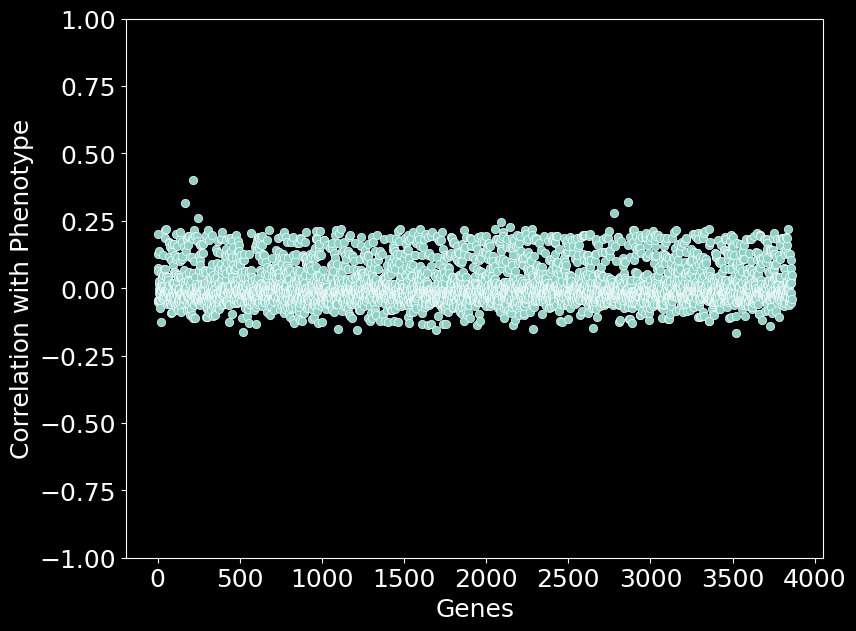

In [ ]:
fig, ax = plt.subplots(figsize = (9,7))
sns.scatterplot(corr_target.values.flatten())
ax.set_ylim([-1, 1])
ax.set_xlabel("Genes")
ax.set_ylabel("Correlation with Phenotype")
plt.show()

## Plot the Entire Dataset - T-sne <br>
Instead of applying tsne on the entire dataset with 3000 genes, owing to computational expense, I first use TruncatedSVD and then employ tsne

In [ ]:
svd = TruncatedSVD(n_components = 100, n_iter = 7, random_state = 11) #calculated SVD for 100 components
svd.fit(df_data.iloc[:,1:-1])

TruncatedSVD(n_components=100, n_iter=7, random_state=11)

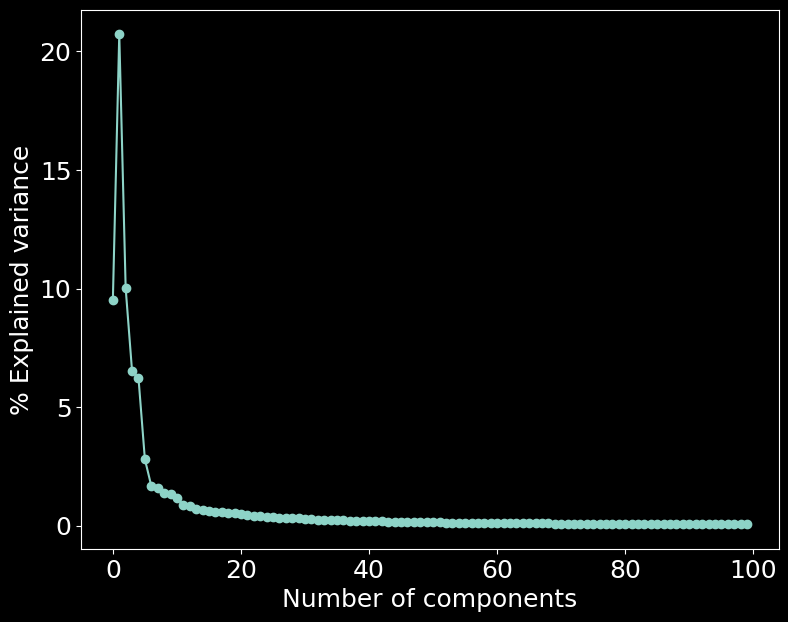

In [ ]:
fig, ax = plt.subplots(figsize = (9,7))
plt.plot(svd.explained_variance_ratio_*100, 'o-')
ax.set_xlabel("Number of components")
ax.set_ylabel("% Explained variance")
plt.show()

**Obervation**:
Using only 20 of these components to plot tsne plot to visualize the entire dataset

In [ ]:
svd_final = TruncatedSVD(n_components = 20, n_iter = 7, random_state = 11)
df_LEV_svd = svd_final.fit_transform(df_data.iloc[:,:-1])
tsne = TSNE(n_components = 2, n_iter = 300)
tsne_results = tsne.fit_transform(df_LEV_svd)

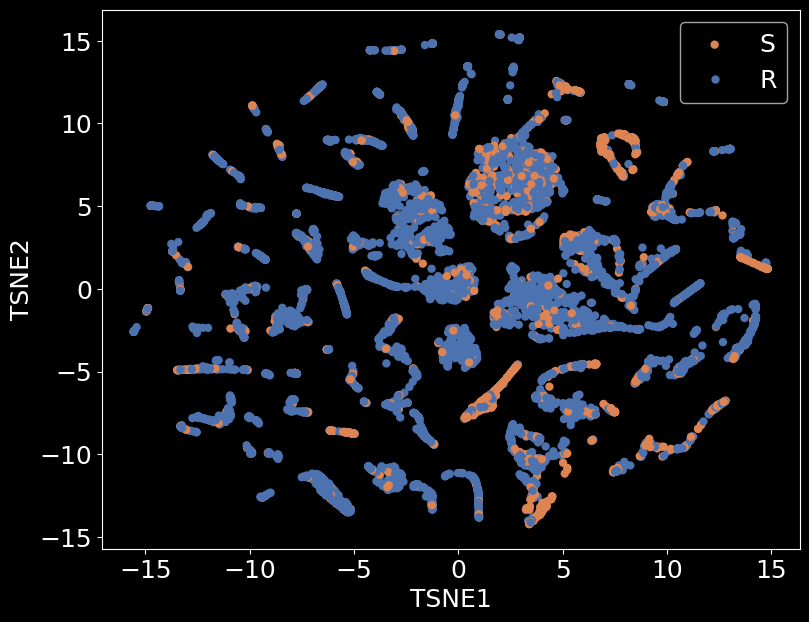

In [ ]:
fig, ax = plt.subplots(figsize = (9,7))
sns.scatterplot(x = tsne_results[:,0], y = tsne_results[:,1], hue = df_data.PHENOTYPE.values, ax = ax, palette = "deep", edgecolor = "none")
ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.legend(['S', 'R'])
plt.show()

## Create an undirected-Gene Regulatory network

In [ ]:
df_regulation.head()

,TF,Target,Sign
0,Rv0022c,Rv0029,1
1,Rv0022c,Rv0030,1
2,Rv0022c,Rv0031,1
3,Rv0022c,Rv0069c,1
4,Rv0022c,Rv0070c,1


In [ ]:
G = nx.DiGraph()
head = df_regulation.shape[0]
df_small = df_regulation.iloc[0:10,:] #plotting the regulator and the 10 genes it regulates
G = nx.from_pandas_edgelist(df_small, 'TF','Target', create_using = G)
#G.add_nodes_from(df_small['Target'])
#edges = [(row['TF'], row['Target']) for index,row in df_small.iterrows()]

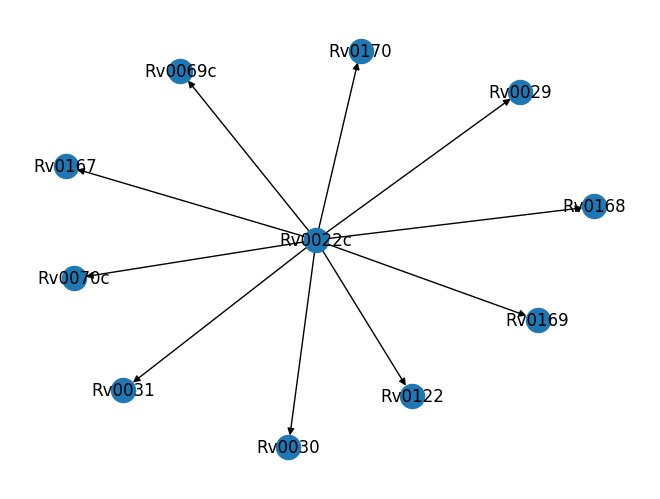

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G,pos, with_labels = True)
plt.show()

In [ ]:
nodes_with_zerodeg = [node for node in G if G.in_degree(node) == 0]

In [ ]:
len(nodes_with_zerodeg)

1

**Observation**: <br>
When points are clustered they are still together

In [ ]:
def get_val_train_curve(model, par, classification = False):
  par_name = list(par.keys()) # get the parameter names
  df = pd.DataFrame(model.cv_results_)# create dataframe from cv_results_
  fig, axes = plt.subplots(1,len(par_name), figsize = (10,8)) #define fig and axes
  fig.tight_layout(pad = 2) #increase the padding
  if classification: # if it was classification
    factor_mul = 1 #set to 1
    Error = "Accuracy"
  else:
    Error = "MSE"
    factor_mul = -1 #else set to -1. -1 is for mse

  if len(par_name) == 1: #if only one
    test_error = df['mean_test_score'] #get mean val_error from df
    std_test_error = df['std_test_score'] #get std of val_error from df
    train_error = df['mean_train_score'] #get train_error from df
    std_train_error = df['std_train_score'] #get std of train_error from df
    axes.plot(par[par_name[0]], factor_mul*test_error, label = "valid", lw = 2) #plot validation error
    axes.fill_between(par[par_name[0]], factor_mul*(test_error-std_test_error), factor_mul*(test_error+std_test_error), alpha = 0.2) #create std band around mean val_error
    axes.plot(par[par_name[0]], factor_mul*train_error, label = "train", lw = 2) #plot train_error
    axes.fill_between(par[par_name[0]], factor_mul*(train_error-std_train_error), factor_mul*(train_error+std_train_error), alpha = 0.2) #create std band around mean train_error
    axes.set_ylabel(Error)
  else: #else iterate
    for index, p in enumerate(par_name): #iterate over hyperparameters
      best_val = model.best_params_[p] #get the best value of one parameter
      test_error = df[df['param_'+str(p)] == best_val].loc[:,'mean_test_score'] # for the best value get the values of test error for other parameter
      std_test_error = df[df['param_'+str(p)] == best_val].loc[:,'std_test_score'] # for the best value get std of test error for other
      train_error = df[df['param_'+str(p)]== best_val].loc[:,'mean_train_score'] #for best value get values of train error for other
      std_train_error = df[df['param_'+str(p)]== best_val].loc[:,'std_train_score'] #for best value get values of std of train error for other
      axes[index].plot(par[par_name[1-index]], factor_mul*test_error, label = "valid", lw = 2) #plot test error
      axes[index].fill_between(par[par_name[1-index]], factor_mul*(test_error-std_test_error), factor_mul*(test_error+std_test_error), alpha = 0.2) #plot std as band around the mean
      axes[index].plot(par[par_name[1-index]], factor_mul*train_error, label = "train", lw = 2) #plot train error
      axes[index].fill_between(par[par_name[1-index]], factor_mul*(train_error-std_train_error), factor_mul*(train_error+std_train_error), alpha = 0.2) #plot std as band around the mean
      axes[index].set_xlabel(par_name[1-index])
    axes[0].set_ylabel(Error)


## There are no duplicated samples


In [ ]:
df_data.duplicated().sum()

0

## Data pre-processing

In [ ]:
#genes_crossresistance = ["rpoB", "katG", "inhA", "embB", "pncA", "Rv0678", "Rv1979c", "rplC", "ddn", "rrs", "eis", "rpsL", "rrs", "gid", "ethA"]
#genes_LEVresistance = ["gyrA", "gyrB"]
#list(corr_list)
threshold_prob = 2
genes_SoverR = genes[probSoverR>threshold_prob] #mutated genes present in susceptible in greater fractions than in resistant
genes_to_remove = list(corr_list) + list(genes_SoverR)
#genes_to_remove = [genes for genes in genes_to_remove if genes not in genes_LEVresistance]
print(f"From {X_train.shape[1]} features, I remove: {len(set(genes_to_remove))}")
X_process = X_train.drop(genes_to_remove, axis = 1)
X_process_test = X_test.drop(genes_to_remove, axis = 1)
print(f"Final shape of training data is {X_process.shape[0]}x{X_process.shape[1]}")

From 3861 features, I remove: 679
Final shape of training data is 8945x3182


# Baseline Score

$ w(i) = \frac{N_{samples}}{N_{class}×count(i)}$, this weight is added to loss-function. <br>
A minority class will have greater weight. <br>
Hence the optimizer is incentized to minimize mis-classification of the minority class

In [ ]:
class_weight = "balanced"
scale_pos_weight = (1-np.mean(y_train))/(np.mean(y_train))
models = [
    ('LinClass', LogisticRegression(class_weight = class_weight, max_iter = 100000)),
    ('KNN', KNeighborsClassifier()),
    ('SV', SVC(kernel = "rbf", class_weight = class_weight)),
    ('RF', RandomForestClassifier(class_weight = class_weight)),
    ('Ada', AdaBoostClassifier()),
    ('XG', XGBClassifier(scale_pos_weight = scale_pos_weight))
]

scoring = ['balanced_accuracy','f1_weighted','roc_auc']

shuffle is set to False, because I don't want training and test data to overlap

In [ ]:
scale_pos_weight

4.002796420581656

In [ ]:
model_names = []
cv_estimators = []
n_splits = 10
for name, estimator in models:
  kfold = StratifiedKFold(n_splits = n_splits, shuffle = False)
  scores = cross_validate(estimator,
                              X_process,
                              y_train,
                              cv = kfold,
                              scoring = scoring,
                              return_train_score = True)
  cv_estimators.append(scores)
  model_names.append(name)
  #print(scores.keys())
  print(f"{name} has accuracy(balanced): {scores['test_balanced_accuracy'].mean():.2f} and roc: {scores['test_roc_auc'].mean():.2f} with fitting time: {scores['fit_time'].mean():.2f} s")

LinClass has accuracy(balanced): 0.74 and roc: 0.79 with fitting time: 84.27 s
KNN has accuracy(balanced): 0.69 and roc: 0.78 with fitting time: 0.42 s
SV has accuracy(balanced): 0.78 and roc: 0.85 with fitting time: 109.58 s
RF has accuracy(balanced): 0.72 and roc: 0.84 with fitting time: 9.17 s
Ada has accuracy(balanced): 0.71 and roc: 0.83 with fitting time: 12.79 s
XG has accuracy(balanced): 0.77 and roc: 0.83 with fitting time: 10.73 s


**Observation**: <br>
We see overfitting (training accuracy ~ very higher while testing accuracy is low) for higher values of n_estimators and max_depth. This implies that we can now get the sweat spot. If the training data is not overfitting, then it means that I need to span the parameter space better

In [ ]:
def results2sns(results, property, names):
  prop_array = []
  for ind, model_prop in enumerate(results):
    for val in model_prop[property]:
      prop_array.append([names[ind], val])
  df_box = pd.DataFrame(prop_array, columns = ["models", property])
  fig, ax = plt.subplots(figsize = (9,7))
  sns.boxplot(df_box, x = "models", y = property, ax = ax)



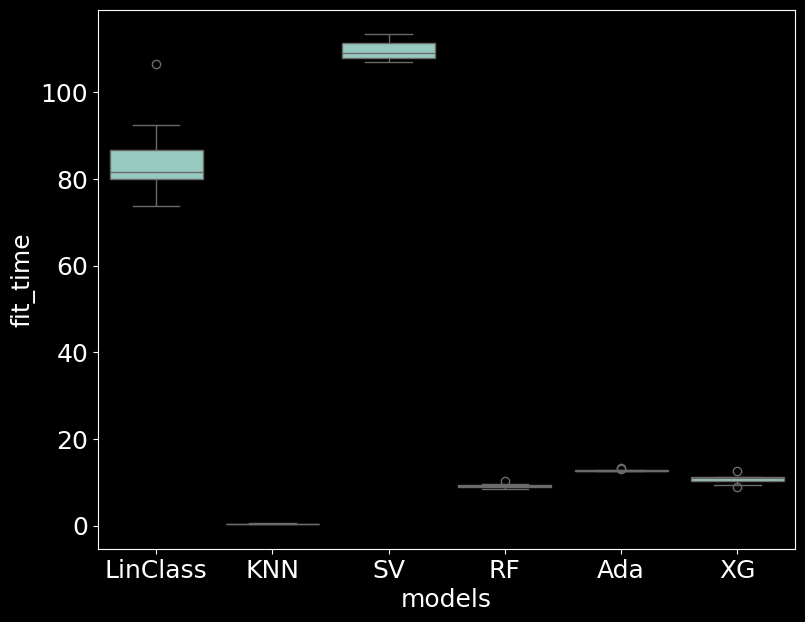

In [ ]:
results2sns(cv_estimators, 'fit_time', model_names)

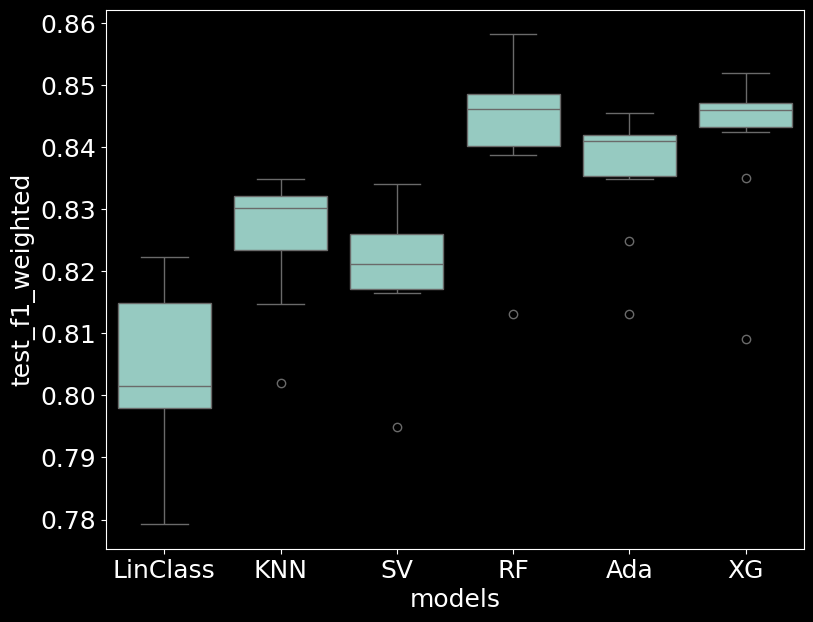

In [ ]:
results2sns(cv_estimators, 'test_f1_weighted', model_names)

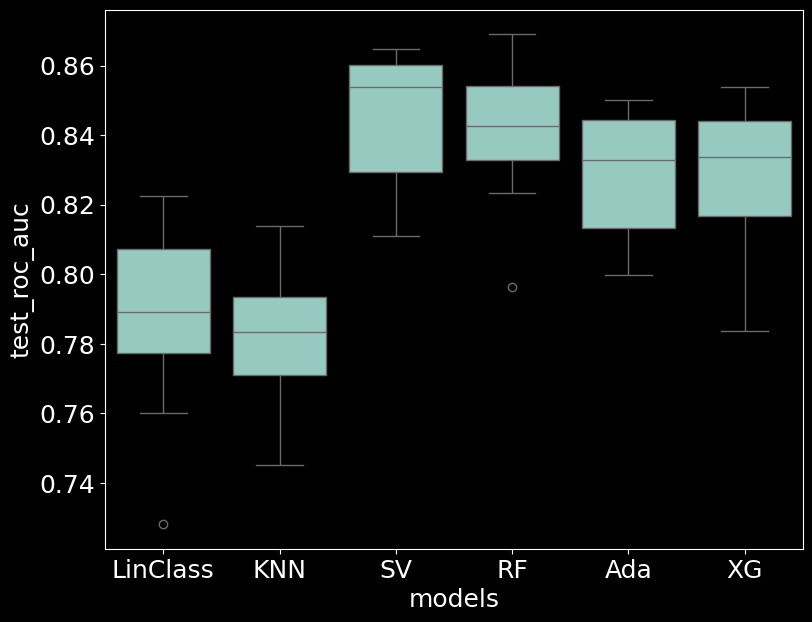

In [ ]:
results2sns(cv_estimators, 'test_roc_auc', model_names)

**Observation**: <br>
RandomForest and XGboost gave comparable scores on f1_weighted and roc_auc. <br> While XGboost had a higher balanced_accuracy score than RandomForest. <br>
SVC also gave good balanced accuracy and roc_auc scores however the time taken for fitting is much higher than other models (why?) <br>
**Next Step**: <br>
Going ahead with RandomForest because Roc_auc is best and time is least

# Feature Engineering and Extraction

In [ ]:
class ColDropper(): #Drop genes based on probability thresholds
  def __init__(self, genes, corr_genes, probSoverR, threshold = 2):
    self.threshold = threshold
    self.genes = genes
    self.corr_genes = corr_genes
    self.probSoverR = probSoverR
  def fit(self, X, y = None):
    genes_SoverR = self.genes[self.probSoverR>self.threshold] #mutated genes present in susceptible in greater fractions than in resistant
    self.genes_to_remove = list(self.corr_genes) + list(genes_SoverR)

  def transform(self, X, y = None):
    X_temp = X.copy()
    X_temp = X_temp.drop(self.genes_to_remove, axis = 1)
    return X_temp

  def fit_transform(self, X, y = None):
    X_temp = X.copy()
    genes_SoverR = self.genes[self.probSoverR>self.threshold] #mutated genes present in susceptible in greater fractions than in resistant
    self.genes_to_remove = list(self.corr_genes) + list(genes_SoverR)
    X_temp = X_temp.drop(self.genes_to_remove, axis = 1)
    return X_temp

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self



Creates an issue because newer dataframes would want the whole set

In [ ]:
dropcol = ColDropper(genes, corr_list, probSoverR, threshold = 1)
X_process2 = dropcol.fit_transform(X_train, y_train)
X_process2.head()

,eccB1,eccB2,Rv2331,eccB4,Rv2336,Rv0008c,infC,Rv3629c,Rv3669,Rv1883c,...,gabD1,Rv3541c,Rv3196,mutA,Rv0574c,Rv2366c,Rv1006,Rv3651,Rv1703c,Rv1882c
1083,1,1,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5253,0,0,1,1,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
9148,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2384,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6115,1,0,0,1,0,1,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0


## GridSearchCV to get the bounded regions

In [ ]:
RF = RandomForestClassifier(class_weight = "balanced")
param_grid = {
    'max_depth': np.linspace(40,100,5, dtype = int),
    'n_estimators': np.linspace(80,150,5, dtype = int)
}
n_splits = 5
kfolds = StratifiedKFold(n_splits)
Grid_fe = GridSearchCV(RF,
                       param_grid,
                       scoring = 'roc_auc',
                       cv = kfolds, #80:20 between train:validation
                       verbose = 5,
                       n_jobs = -1, #use the CPUs in the system
                       return_train_score = True
                       )
Grid_fe.fit(X_process, y_train)
print(f"Best Scores: {Grid_fe.best_score_}")
print(f"Best parameters: {Grid_fe.best_params_}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Scores: 0.8422466915510801
Best parameters: {'max_depth': 40, 'n_estimators': 150}


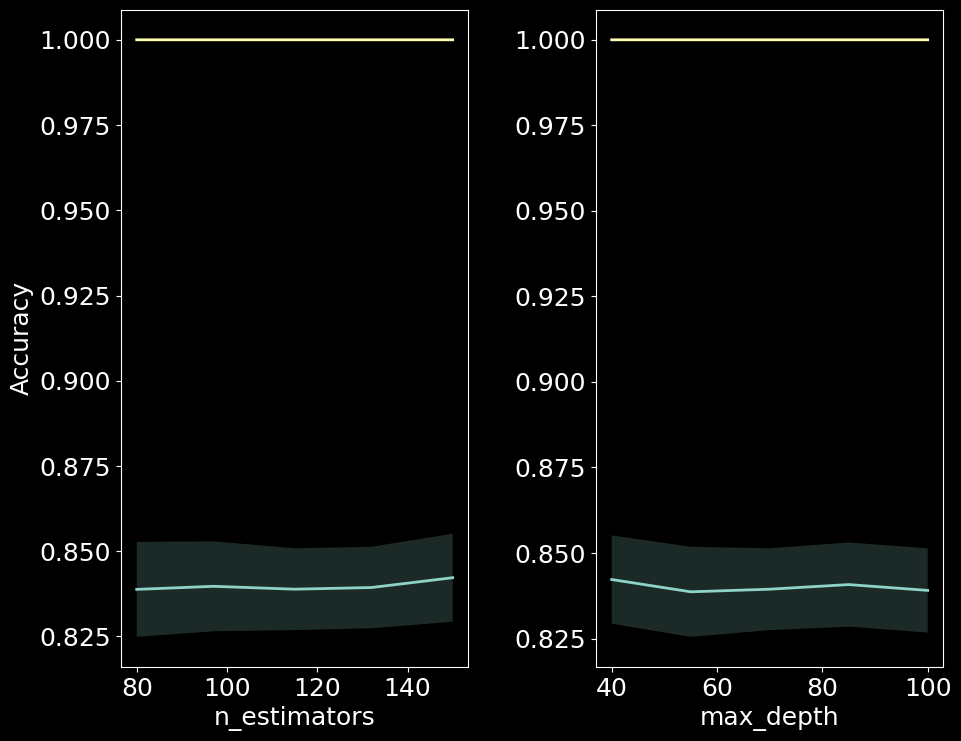

In [ ]:
get_val_train_curve(Grid_fe, param_grid, classification = True)

**Observation**: <br>
GridSearchCV is used to get the range where the model overfits on training data but performs poorly on the validation data <br>


## RandomizedSearchCV

In [ ]:
RF = RandomForestClassifier(class_weight = "balanced")
param_dist = {
    'max_depth': sp_rand(40,100),
    'n_estimators': sp_rand(80,150)
}
n_splits = 5
kfolds = StratifiedKFold(n_splits)
RandSearch_fe = RandomizedSearchCV(RF,
                       param_dist,
                       n_iter = 100,
                       scoring = 'roc_auc',
                       cv = kfolds, #80:20 between train:validation
                       verbose = 5,
                       n_jobs = -1, #use the CPUs in the system
                       return_train_score = True
                       )
RandSearch_fe.fit(X_process, y_train)
print(f"Best Scores: {RandSearch_fe.best_score_}")
print(f"Best parameters: {RandSearch_fe.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Scores: 0.8418567190295064
Best parameters: {'max_depth': 42, 'n_estimators': 149}


Check whether n_estimators range needs to increase

908      0
9682     0
7697     1
10659    0
2150     1
Name: PHENOTYPE, dtype: int64

In [ ]:
best_estimator = RandSearch_fe.best_estimator_
y_predict = best_estimator.predict(X_process_test)
print(classification_report(y_test, y_predict, target_names = ["Resistant", "Susceptible"]))

              precision    recall  f1-score   support

   Resistant       0.88      0.95      0.91      1790
 Susceptible       0.70      0.49      0.58       447

    accuracy                           0.86      2237
   macro avg       0.79      0.72      0.75      2237
weighted avg       0.85      0.86      0.85      2237



**Observation**: <br>
Not doing great with Susceptible. The model is predicting them to be resistant.


# Backward feature elimination using Recursive Feature Extraction using Cross Validation

In [ ]:
estimator = RandomForestClassifier(class_weight = "balanced", max_depth = 42, n_estimators = 149)
n_splits = 5
n_drops = 200 #number of features to drop
cv = StratifiedKFold(n_splits)
min_features_to_select = 10
selector = RFECV(estimator, step = n_drops, cv = cv, min_features_to_select = min_features_to_select, scoring = 'roc_auc')
selector.fit(X_process,y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(class_weight='balanced', max_depth=42,
                                       n_estimators=149),
      min_features_to_select=10, scoring='roc_auc', step=200)

In [ ]:
#filename = 'RFECV_10drops_1000min.joblib'
#joblib.dump(selector,filename)

['RFECV_10drops_1000min.joblib']

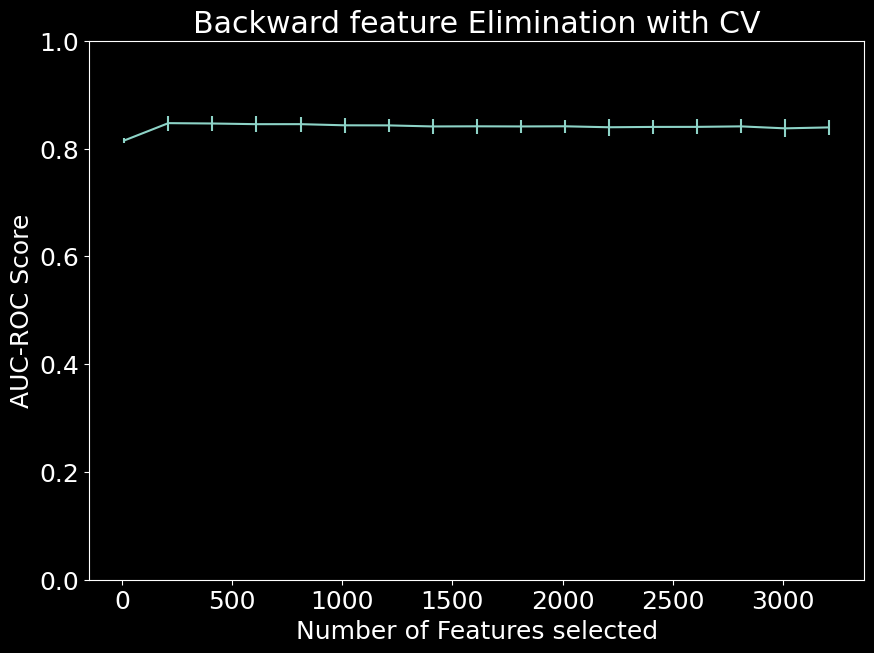

In [ ]:
n_scores = len(selector.cv_results_["mean_test_score"])
plt.figure(figsize = (10,7))
plt.errorbar(
    range(min_features_to_select, (n_scores)*n_drops+min_features_to_select, n_drops),
    selector.cv_results_["mean_test_score"],
    yerr = selector.cv_results_["std_test_score"]
)
plt.xlabel("Number of Features selected")
plt.ylabel("AUC-ROC Score")
plt.ylim([0, 1])
plt.title("Backward feature Elimination with CV")
plt.show()

In [ ]:
range(min_features_to_select, n_scores*n_drops+min_features_to_select, n_drops)

range(1000, 3200, 10)

In [ ]:
len(selector.cv_results_["mean_test_score"])

17

In [ ]:
genes_mask = selector.support_
genes_selected = X_process.columns[genes_mask]

In [ ]:
"gyrA" in genes_selected

False

In [ ]:
"gyrB" in genes_selected

True

In [ ]:
#scale_pos_weight = (1-np.mean(y_train))/(np.mean(y_train))
#xgb = XGBClassifier(scale_pos_weight = scale_pos_weight)
#pipeline_fe = Pipeline([
#    ('dropcol', ColDropper(genes, corr_list, probSoverR)),
#    ('xgb', XGBClassifier(scale_pos_weight = scale_pos_weight))
#])
#param_grid = {
#    'max_depth': [1, 3, 7, 10],
#    'subsample': np.linspace(0.1,1,4)
#}
#n_splits = 5
#kfolds = StratifiedKFold(n_splits)
#Grid_fe = GridSearchCV(xgb,
#                       param_grid,
#                       scoring = 'roc_auc',
#                       cv = kfolds, #80:20 between train:validation
#                       verbose = 5,
#                       n_jobs = -1, #use the CPUs in the system
#                       return_train_score = True
                       )
#Grid_fe.fit(X_process, y_train)
#print(f"Best Scores: {Grid_fe.best_score_}")
#print(f"Best parameters: {Grid_fe.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Scores: 0.8401293253326066
Best parameters: {'max_depth': 1, 'subsample': 1.0}


**Observation**: <br>
1. *Removing Correlated Genes*: Reduced Accuracy <br>
2. *Removing SoverR genes*: Reduced Accuracy <br>
3. *Removing only cross-resistance*: Reduced Accuracy <br>
4. *Including genes cross-resistance*: Increased Accuracy <br>
But this is leaky information


# Machine Learning Model training

In [ ]:
annotated = pd.read_csv("Annotation.csv")

In [ ]:
annotated.head(n=10)

,Accession,Locus,Start,End,Strand,Gene,Product
0,cluster_001_consensus_pilon_pilon_pil>,Rv0001,0,1524,1,dnaA,chromosomal replication initiator protein DnaA
1,cluster_001_consensus_pilon_pilon_pil>,Rv0002,2051,3260,1,dnaN,DNA polymerase III subunit beta
2,cluster_001_consensus_pilon_pilon_pil>,Rv0003,3279,4437,1,recF,DNA replication/repair protein RecF
3,cluster_001_consensus_pilon_pilon_pil>,Rv0004,4433,4997,1,NaN,DNA replication protein DciA
4,cluster_001_consensus_pilon_pilon_pil>,Rv0005,5239,7267,1,gyrB,DNA topoisomerase (ATP-hydrolyzing) subunit B
5,cluster_001_consensus_pilon_pilon_pil>,Rv0006,7301,9818,1,gyrA,DNA topoisomerase (ATP-hydrolyzing) subunit A
6,cluster_001_consensus_pilon_pilon_pil>,Rv0007,9913,10828,1,NaN,DUF3566 domain-containing protein
7,cluster_001_consensus_pilon_pilon_pil>,Rv1_000010,11224,11416,1,NaN,hypothetical protein
8,cluster_001_consensus_pilon_pilon_pil>,Rv1_000011,11554,11692,-1,NaN,hypothetical protein
9,cluster_001_consensus_pilon_pilon_pil>,Rv0008c,11873,12311,-1,cwsA,cell wall synthesis protein CwsA


**Observation**: <br>
All the Locus tags have Rv at the start

In [ ]:
annotated.Locus.dropna().duplicated().sum()

0

None of the LocusID are duplicated

In [ ]:
annotated.Gene.dropna().duplicated().sum()

14

Gene names are duplicated

In [ ]:
count = 0
geneswithRv = [gene for gene in annotated.Locus.values.tolist() if gene.startswith("Rv")]
print(f"{len(geneswithRv)} Locus have Rv at the start")

4105 Locus have Rv at the start


In [ ]:
def gene2locus(df, annotation):
  names = df.columns.values.copy()
  count = 0
  loc_names, rej_names = [], []
  for name in names:
    if name in loc_names: #print duplicates
      print(name)
    if name in annotation.Locus.values:
      loc_names.append(name)
    elif name in annotation.Gene.values:
      loc_names.append(annotation.Locus.values[annotation.Gene.values==name][0])
    else:
      count+=1
      rej_names.append(name)
      loc_names.append(name)

  print(f"{count} did not match")
  return loc_names, rej_names

def reordercols(df, gene_names, gene_notaligned, ref_names):
  df_new = df.copy()
  df_new.columns = gene_names
  ordered = [gene for gene in gene_names if gene not in gene_notaligned]
  disordered = [gene for gene in gene_names if gene in gene_notaligned]
  #to_order = [gene for gene in df.columns.values if gene.startswith("Rv") & (gene in to_order)]
  to_order = [gene for gene in ref_names if (gene in ordered)]

  df_ordered = df_new.loc[:,ordered].copy()
  df_disordered = df_new.loc[:,disordered].copy()
  df_ordered = df_ordered[to_order]
  #print(df_ordered.shape)
  print(f"Length of ref_names: {len(ref_names)}, ordered:{len(ordered)}, to_order:{len(to_order)} disordered:{len(disordered)}")
  df_final = df_ordered.join(df_disordered)
  return df_final


In [ ]:
all_names, unconverted_names = gene2locus(X_process, annotated)

Rv2038c
350 did not match


In [ ]:
(np.array(genes)=='Rv2038c').sum()

1

In [ ]:
(np.array(all_names)=='Rv2038c').sum()

2

In [ ]:
annotated.Gene.values[annotated.Locus.values == 'Rv2038c'] = 'NaN'

In [ ]:
all_names, unconverted_names = gene2locus(X_process, annotated)

350 did not match


In [ ]:
annotated.Gene.values[annotated.Locus.values == 'Rv2832c']

array(['ugpC'], dtype=object)

**Observation** <br>
Rv2832c and Rv2038c have been given the gene names ugpC <br>
Manually, removing the name ugpC from Rv2038c <br>
Rv1151c was present both as a locus and gene name in the original datafile X_train, <br>


In [ ]:
all_names, unconverted_names = gene2locus(X_process, annotated)

350 did not match


In [ ]:
namesinannotated = [gene for gene in annotated.Locus.values if gene in all_names]
print(len(namesinannotated))

2831


In [ ]:
print(f"Does the all_names list have duplicated gene names: {len(all_names)!=len(set(all_names))}")

Does the all_names list have duplicated gene names: True


In [ ]:
def listduplicated(list):
  counter = []
  duplicated = []
  for l in list:#for each name
    counter = list.count(l) #count its occurance
    if counter > 1: #check if is repeated
      if duplicated.count(l) == 0: #check if it is already present in duplicated
        duplicated.append(l) #add to the list
  return duplicated

listduplicated(all_names)

['Rv1151c']

In [ ]:
annotated.Gene.values[annotated.Locus.values == 'Rv1151c']

array(['cobB'], dtype=object)

In [ ]:
'Rv1151c' in genes

True

In [ ]:
X_process.loc[:,'Rv1151c'].sum()

186

In [ ]:
test_dup = X_process.loc[:,'Rv1151c'] + X_process.loc[:, 'cobB']

In [ ]:
X_process_dedup = X_process.copy()
X_process_dedup.loc[:,'Rv1151c'] = X_process.loc[:,'Rv1151c'] + X_process.loc[:,'cobB']

In [ ]:
X_process_dedup.loc[:,'Rv1151c'][X_process_dedup.loc[:,'Rv1151c'] > 1] = 1

In [ ]:
X_process_dedup = X_process_dedup.drop(['cobB'], axis = 1)

In [ ]:
len(X_process_dedup.columns.values)

3181

In [ ]:
all_names, unconverted_names = gene2locus(X_process_dedup, annotated)
X_process_order_train = reordercols(X_process_dedup, all_names, unconverted_names, annotated.Locus.values)

350 did not match
Length of ref_names: 4106, ordered:2831, to_order:2831 disordered:350


In [ ]:
X_process_order_train.head()

,Rv0001,Rv0002,Rv0004,Rv0005,Rv0006,Rv0007,Rv0008c,Rv0010c,Rv0011c,Rv0013,...,Rv3178,Rv2310,Rv2311,Rv2886c,Rv2708c,Rv3649,Rv3673c,gabD1,Rv3192,Rv3196
1083,1,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5253,0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
9148,0,1,0,0,1,1,1,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2384,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6115,0,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
X_process_dedup_test = X_process_test.copy()
X_process_dedup_test.loc[:,'Rv1151c'] = X_process_test.loc[:,'Rv1151c'] + X_process_test.loc[:,'cobB']
X_process_dedup_test.loc[:,'Rv1151c'][X_process_dedup_test.loc[:,'Rv1151c'] > 1] = 1
X_process_dedup_test = X_process_dedup_test.drop(['cobB'], axis = 1)
X_process_order_test = reordercols(X_process_dedup_test, all_names, unconverted_names, annotated.Locus.values)

Length of ref_names: 4106, ordered:2831, to_order:2831 disordered:350


In [ ]:
mut_density_position = X_process_order_train[y_train == 1].sum(axis = 0)
sus_density_position = X_process_order_train[y_train == 0].sum(axis = 0)

In [ ]:
figres = px.line(x = np.arange(0,X_process_order_train.shape[1]),
                 y = mut_density_position.values,

                 labels = {'x': 'Genome Position',
                           'y': 'Number of Mutations'},
                 template = template)
figres.show()

figsus = px.line(x = np.arange(0,X_process_order_train.shape[1]),
                 y = sus_density_position.values,
                 labels = {'x': 'Genome Position',
                           'y': 'Number of Mutations'},
                 template = template)
figsus.show()

# Convolution Neural Networks

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 9.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from torch.utils.data import Dataset, DataLoader, sampler
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchmetrics import Accuracy, AUROC
from tqdm import tqdm

In [ ]:
class GenomeDataset(Dataset):
  def __init__(self, df):
    super().__init__() #create DataSet class like the super class
    self.data = df.to_numpy('float32') #create a numpy array

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    features = self.data[idx,:-1]
    labels = self.data[idx,-1]
    return features, labels

## Running a DeepNN

In [ ]:
df_cnn_train = pd.concat([X_process_order_train, y_train], axis = 1)
df_cnn_test = pd.concat([X_process_order_test, y_test], axis = 1)

In [ ]:
dataset_train = GenomeDataset(df_cnn_train)
dataset_test = GenomeDataset(df_cnn_test)

sampler = sampler.WeightedRandomSampler()
dataloader_train = DataLoader(dataset_train,
                              batch_size = 200,
                              shuffle = True)

dataloader_test = DataLoader(dataset_test,
                              batch_size = 200,
                              shuffle = True)


In [ ]:
dataset_train[1]

(array([0., 1., 0., ..., 0., 0., 1.], dtype=float32), 0.0)

In [ ]:
#features, labels = next(iter(dataloader_train))
#print(f"features = {features}\n labels = {labels}")

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(3181,256)
    self.bn1 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256,32)
    self.bn2 = nn.BatchNorm1d(32)
    self.fc3 = nn.Linear(32,1)
    init.kaiming_uniform_(self.fc1.weight)
    init.kaiming_uniform_(self.fc2.weight)
    init.kaiming_uniform_(self.fc3.weight, nonlinearity = "sigmoid")

  def forward(self, x):
    x = self.fc1(x)
    x = self.bn1(x)
    x = nn.functional.elu(x)

    x = self.fc2(x)
    x = self.bn2(x)
    x = nn.functional.elu(x)

    x = nn.functional.sigmoid(self.fc3(x))
    return x



In [ ]:
getattr(GenomeDataset)

TypeError: getattr expected at least 2 arguments, got 1

In [ ]:
net = Net()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)


for epoch in range(100): #https://towardsdatascience.com/training-models-with-a-progress-a-bar-2b664de3e13e
  with tqdm(dataloader_train, unit = "batch") as tepoch:
    tepoch.set_description(f"Epoch {epoch}")
    for features, labels in tepoch:
      optimizer.zero_grad()
      outputs = net(features)
      loss = criterion( #convert to a column tensor
          outputs,
          labels.view(-1,1)
      )
      loss.backward()
      optimizer.step()

Epoch 813:  51%|█████     | 23/45 [00:01<00:01, 19.65it/s]

In [ ]:
acc = AUROC(task = "binary")
net.eval()
#
with torch.no_grad():
  for features, labels in dataloader_test:
    outputs = net(features)
    preds = (outputs >= 0.5).float()
    acc(preds, labels.view(-1,1))

accuracy = acc.compute()

In [ ]:
accuracy

tensor(0.7056)

**Observation** <br>
As a test case, trained the model on a single sample. Overfitting would imply correct implementation would ensure that the implementation is fine.


# Deploy the app